In [25]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler


sales_doc = "../doccuments/sales_and_eodStocks.xlsx"
transactions_doc = "../doccuments/transactions.xlsx"

sales_df = pd.read_excel(sales_doc)
transactions_df = pd.read_excel(transactions_doc)
print(sales_df.head())
print(transactions_df.head())

def scale_data(df, columns, method='standardization'):
    """
    Scale the specified columns of the dataframe using the chosen method.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    columns (list): List of column names to be scaled.
    method (str): The scaling method - 'standardization' or 'normalization'.

    Returns:
    pandas.DataFrame: The dataframe with the specified columns scaled.
    """
    scaler = StandardScaler() if method == 'standardization' else MinMaxScaler()

    # Scale only the specified columns
    df_scaled = df.copy()
    df_scaled[columns] = scaler.fit_transform(df_scaled[columns])

    return df_scaled
# sales_df = scale_data(sales_df,['Sales'])
print(sales_df.head())
print(transactions_df.head())

  Product_ID       Date  Sales  Revenue  EndOfDayStock
0      10002 2009-12-01     12    10.20          48692
1      10002 2009-12-03      7     5.95          48685
2      10002 2009-12-04     73    62.05          48612
3      10002 2009-12-06     49    41.65          48563
4      10002 2009-12-07      2     1.70          48561
   Invoice Product_ID                          Description  Quantity  \
0   489434      85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434     79323P                   PINK CHERRY LIGHTS        12   
2   489434     79323W                  WHITE CHERRY LIGHTS        12   
3   489434      22041         RECORD FRAME 7" SINGLE SIZE         48   
4   489434      21232       STRAWBERRY CERAMIC TRINKET BOX        24   

                 Date  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95        13085  United Kingdom  
1 2009-12-01 07:45:00   6.75        13085  United Kingdom  
2 2009-12-01 07:45:00   6.75        13085  United Kingdom

Date
2009-12-01    132.0
2009-12-02    363.0
2009-12-03     54.0
2009-12-04      5.0
2009-12-05     24.0
              ...  
2010-08-18      7.0
2010-08-19     72.0
2010-08-20     72.0
2010-08-21     72.0
2010-08-22     72.0
Freq: D, Name: Sales, Length: 265, dtype: float64
Date
2010-08-23    48.0
2010-08-24    48.0
2010-08-25    26.0
2010-08-26    28.0
2010-08-27    25.0
              ... 
2010-10-24    84.0
2010-10-25    27.0
2010-10-26    24.0
2010-10-27    48.0
2010-10-28    24.0
Freq: D, Name: Sales, Length: 67, dtype: float64


/var/folders/cb/vn84n7fd0mxdxb86fk4ykq4c0000gn/T/ipykernel_30100/3220449594.py:109: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  product_data.fillna(method='ffill', inplace=True)
/Users/ioancristianlefter/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ioancristianlefter/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ioancristianlefter/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as sta

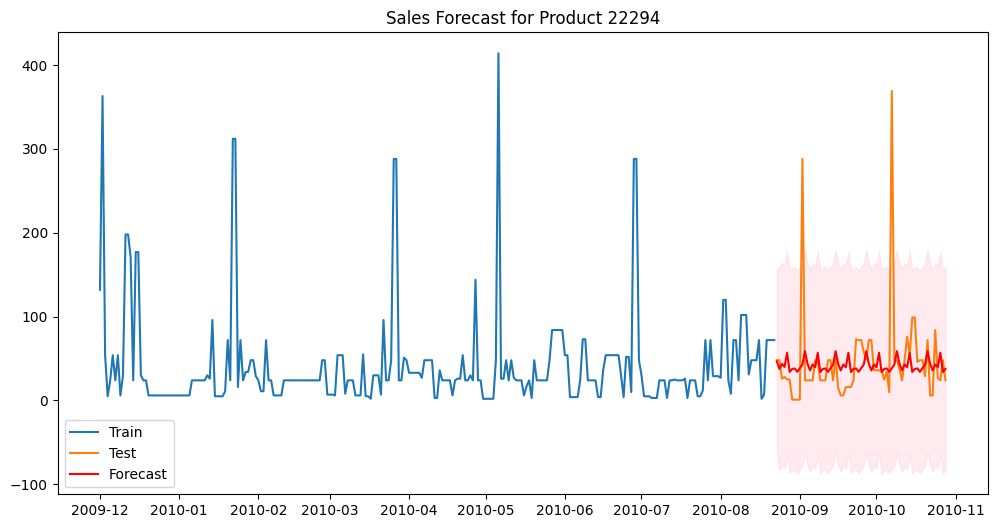

Best Orders:  ((2, 0, 2), (1, 1, 1, 12))
                                      SARIMAX Results                                       
Dep. Variable:                                Sales   No. Observations:                  265
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood               -1390.928
Date:                              Sat, 09 Dec 2023   AIC                           2795.856
Time:                                      20:00:40   BIC                           2820.589
Sample:                                  12-01-2009   HQIC                          2805.807
                                       - 08-22-2010                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1453      1.417      0.103      0.918   

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
import matplotlib.pyplot as plt
from itertools import product
from datetime import date
import numpy as np



def optimize_sarima(train, d=0, D=1, m=12, max_p=3, max_q=4, max_P=3, max_Q=2):
    """
    Perform grid search to find the best SARIMA model parameters (p, d, q) x (P, D, Q, m).

    Parameters:
    train (pd.Series): Training time series data.
    d, D (int): Differencing parameters for non-seasonal and seasonal parts.
    m (int): Number of periods in each season.
    max_p, max_q, max_P, max_Q (int): Maximum values of p, q, P, Q to test.

    Returns:
    tuple: Best (p, d, q, P, D, Q, m) parameters and corresponding RMSE.
    """
    best_rmse = float("inf")
    best_order = None
    best_seasonal_order = None

    for p, q, P, Q in product(range(max_p + 1), range(max_q + 1), range(max_P + 1), range(max_Q + 1)):
        try:
            model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit(disp=False)
            rmse = sqrt(mean_squared_error(train, model.fittedvalues))
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = (p, d, q)
                best_seasonal_order = (P, D, Q, m)
        except:
            continue

    return (best_order, best_seasonal_order), best_rmse


def predict_sales_sarima(product_id, train, test, m=12, max_p=2, max_q=2, max_P=1,
                         max_Q=1):


    """
    Predicts the sales for a particular product using an optimized SARIMA model.

    Parameters:
    product_id (str): The ID of the product to predict sales for.
    data (pd.DataFrame): The dataframe containing the sales data.
    test_size (float): Proportion of the dataset to include in the test split.
    fill_method (str): Method to fill missing values ('ffill', 'bfill', 'interpolate').
    m (int): Number of periods in each season for SARIMA.
    max_p, max_q, max_P, max_Q (int): Maximum values of p, q, P, Q to test in SARIMA.

    Returns:
    dict: A dictionary containing the model summary, RMSE, and a plot of the predictions.
    """

    # Optimize SARIMA parameters
    best_orders, _ = optimize_sarima(train, d=0, D=1, m=m, max_p=max_p, max_q=max_q, max_P=max_P, max_Q=max_Q)

    # Fit the SARIMA model with the best parameters
    model = SARIMAX(train, order=best_orders[0], seasonal_order=best_orders[1])
    model_fit = model.fit(disp=False)

    # Forecast
    forecast = model_fit.get_forecast(steps=len(test))
    forecast_series = forecast.predicted_mean

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, forecast_series))

    # Plotting the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(forecast_series, label='Forecast', color='red')
    plt.fill_between(forecast_series.index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1],
                     color='pink', alpha=0.3)
    plt.title(f'Sales Forecast for Product {product_id}')
    plt.legend()
    plt.show()

    return {
        'best_orders': best_orders,
        'model_summary': model_fit.summary(),
        'rmse': rmse
    }

def dataSplitForTime(product_id,begin_date,end_date, data, test_size=0.2, fill_method='bfill'):

    # Filter the data for the specified product
    product_data = data[(data['Product_ID'] == product_id) & (data['Date']>=begin_date) & (data['Date']<=end_date)].copy()
    if product_data.empty:
        return "No data available for the specified product."

    product_data.set_index('Date', inplace=True)

    # Ensure that the date index has a frequency (daily in this case)
    product_data = product_data.asfreq('D')

    # Handling NaN values after setting frequency
    if product_data['Sales'].isnull().any():
        if fill_method == 'ffill':
            product_data.fillna(method='ffill', inplace=True)
        elif fill_method == 'bfill':
            product_data.fillna(method='bfill', inplace=True)
        elif fill_method == 'interpolate':
            product_data.interpolate(inplace=True)

    # Check if NaNs are still present
    if product_data['Sales'].isnull().any():
        return "NaN values still present in the data after handling."

    # Splitting the data into train and test sets
    sales_data = product_data['Sales']
    if len(sales_data) < 10:
        return "Insufficient data for SARIMA modeling."

    train_size = int((1 - test_size) * len(sales_data))
    if train_size < 5:
        return "Insufficient training data."

    train, test = sales_data[:train_size], sales_data[train_size:]
    if test.empty:
        return "Test data is empty. Adjust the test_size parameter."
    return train,test

from statsmodels.tsa.seasonal import seasonal_decompose

train, test = dataSplitForTime(22294,np.datetime64(pd.Timestamp('2009-10-28')),np.datetime64(pd.Timestamp('2010-10-28'),),sales_df,fill_method='ffill')
print(train)
print(test)
result = predict_sales_sarima(22294, train, test)
if isinstance(result, dict):
    print("Best Orders: ", result['best_orders'])
    print(result['model_summary'])
    print("RMSE: ", result['rmse'])
else:
    print(result)


In [27]:
import pandas as pd


# Assuming 'data' is your DataFrame and 'date' and 'sales' are columns in your DataFrame
# Ensure that 'date' is of datetime type and set as the index
